# 클러스터링 분석

## K-means, GMM, Spectral, HDBSCAN 클러스터링 적용

## XAI 해석 (SHAP, LIME, Permutation Importance 적용)

### 사용할 라이브러리

In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

In [75]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
# macOS에서 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스(-)가 깨질 수 있는 것을 방지함
plt.rcParams['axes.unicode_minus'] = False


### 데이터 불러오기

In [77]:
# 절대경로로 불러옴
df = pd.read_csv("/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/financial_data_processing.csv")

# 기업명을 따로 저장한 후, feature만 따로 분리함
company = df['기업명_그룹']
X_raw = df.drop(columns=["기업명_그룹"])

X_raw

,매출액,영업이익,당기순이익,자산총계,자본총계,자본금,영업활동현금흐름,FCF,이자발생부채,영업이익률,순이익률,ROE(%),ROA(%),부채비율,EPS(원),PER(배),BPS(원),PBR(배),발행주식수(보통주)
0,550.50,-161.80,30.70,3667.75,2108.60,109.00,-100.75,-179.30,1131.45,-31.8390,2.8695,1.97300,0.73100,73.8620,180.50,-12.573055,10894.85,0.8830,20244221.00
1,12376.05,3597.65,3102.20,20087.05,16075.55,2226.00,4070.00,2144.60,1490.90,27.4250,24.1555,23.07200,17.22850,27.3580,6970.05,7.889000,37737.80,1.4685,44398588.00
2,2985.85,485.15,399.15,2658.60,2131.05,60.80,402.70,262.75,93.50,15.9420,13.1745,21.26650,16.57750,25.3705,2101.85,7.054500,11385.10,1.3010,18561782.00
3,304.85,-38.65,-16.20,1309.60,1050.95,416.90,-17.70,-81.65,193.45,-15.4035,-7.9125,2.83681,1.21894,64.8995,8.90,-84.958990,990.40,2.9625,83307187.05
4,1570.65,347.30,337.15,4452.05,3795.65,95.25,422.65,279.90,315.75,21.2385,20.3430,10.42600,8.56450,20.2845,1783.15,47.644500,20017.65,2.6970,19034204.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2916.20,43.50,-10.80,4857.25,3512.00,234.00,219.05,35.40,650.90,0.8570,-1.3665,5.44200,-0.20950,41.4265,147.75,-1.230688,3081.40,0.3525,46803136.00
110,3546.60,1326.70,1517.10,5823.95,4609.95,127.00,871.65,578.45,17.05,33.4820,61.9735,34.41350,27.73950,25.7065,1550.35,28.405000,4775.05,8.6865,97925226.90
111,1500.70,231.35,200.25,2138.10,1406.15,136.15,310.60,174.55,412.05,14.7805,12.5985,17.47700,9.74000,67.3410,707.95,43.567000,5181.40,1.7565,28318224.00
112,4567.00,310.25,223.20,2276.40,1229.40,74.90,260.40,7.95,181.60,6.8610,4.9625,21.60200,11.10450,87.9715,1486.85,9.757500,8304.80,1.5585,15026489.00


### featurer scaling 수행

In [78]:
# StandardScaler로 정규화한다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

### 클러스터링 적용 및 평가 함수 정의

In [79]:
# 클러스터링 성능 평가 함수를 정의함 
# Silhouette Score를 사용함
def evaluate_clustering(model, X, labels=None):
    if (labels is None):
        labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    return labels, score

### 최적의 K 찾기

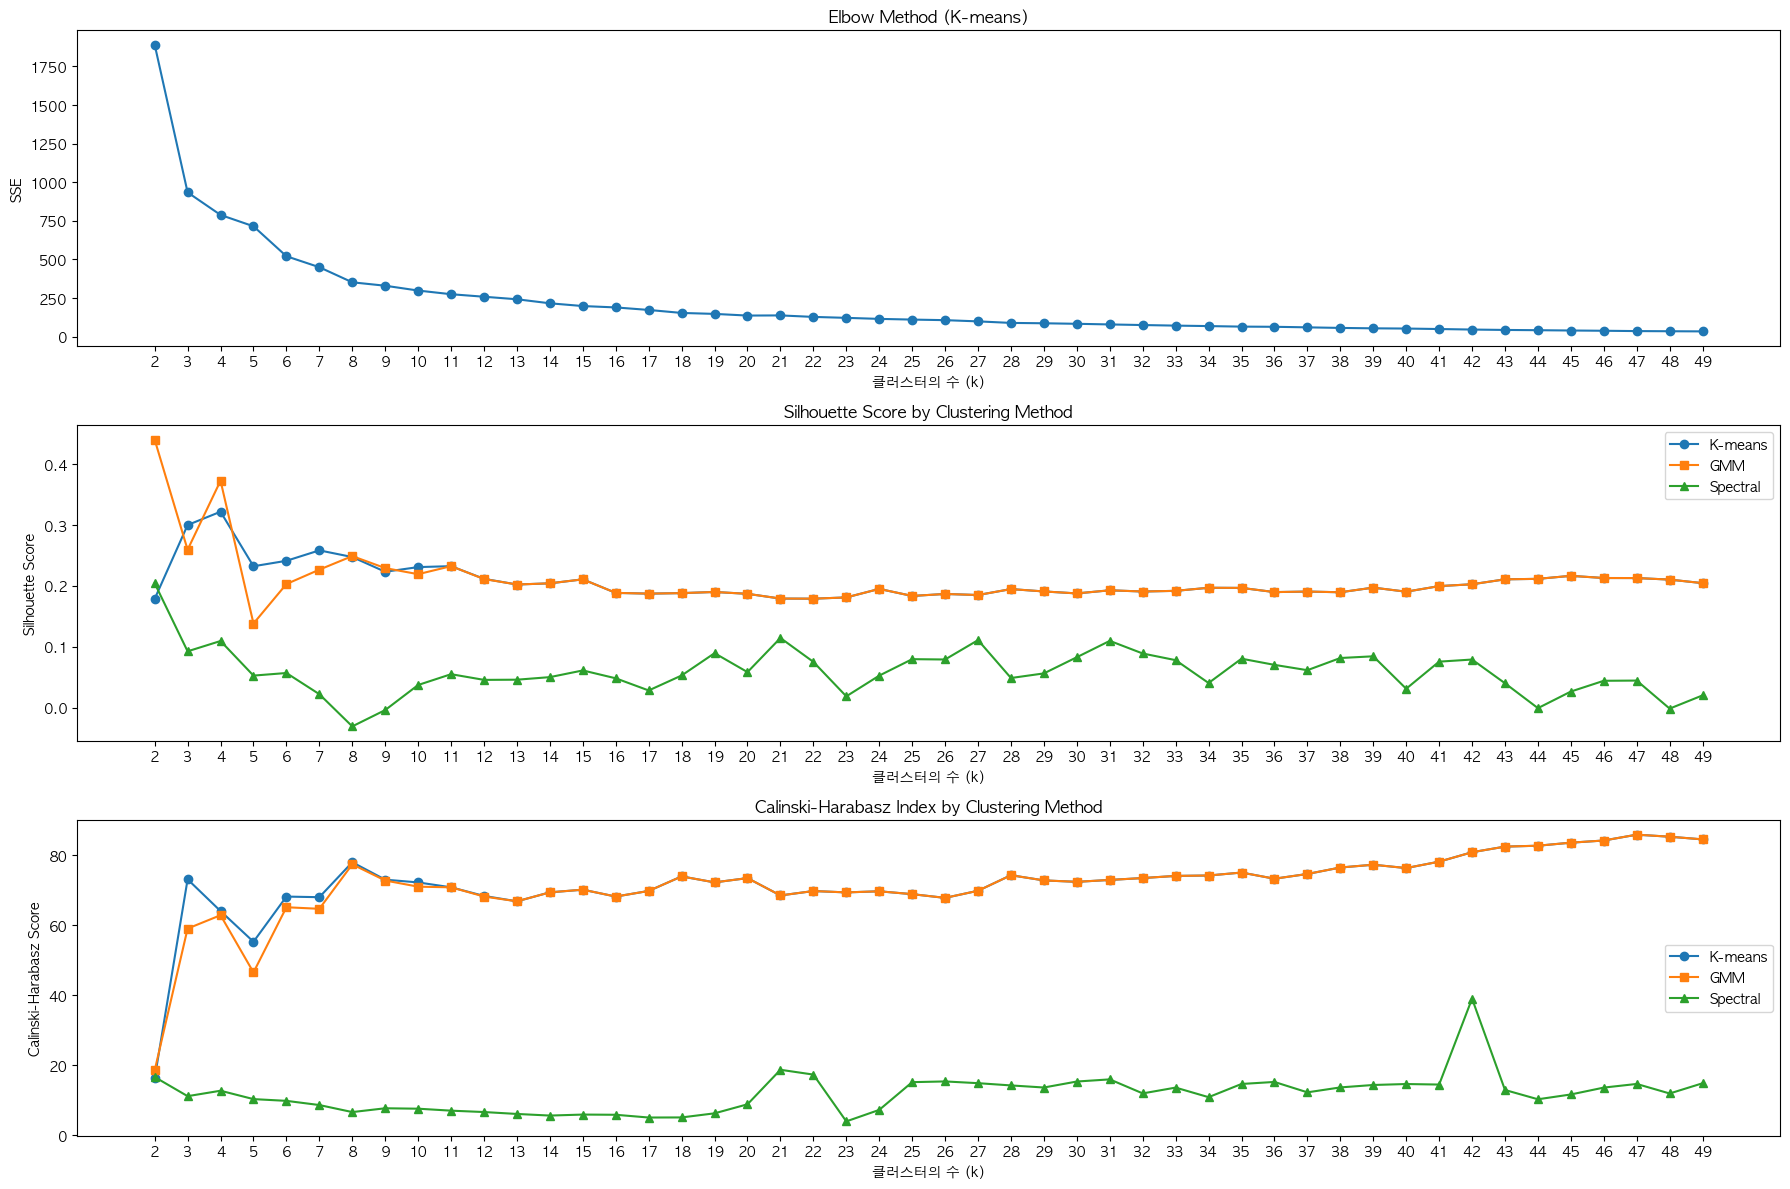

In [80]:
# 후보 K 값 범위 설정
k_values = range(2, 50)

# 결과 저장용 리스트
sse_list = [] # Elbow가 꺽이는 지점 확인용
silhouette_scores = [] # 실루엣 점수가 최대인 지점 확인용
ch_scores = [] # Calinski-Harabasz 점수가 최대인 지점 확인용

gmm_silhouette_scores = []
gmm_ch_scores = []

spectral_silhouette_scores = []
spectral_ch_scores = []

# 각 K에 대해 KMeans, GMM, Spectral 평가
for k in k_values:
    # --- K-means ---
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, kmeans_labels))
    
    # --- GMM ---
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    gmm_silhouette_scores.append(silhouette_score(X_scaled, gmm_labels))
    gmm_ch_scores.append(calinski_harabasz_score(X_scaled, gmm_labels))
    
    # --- Spectral ---
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    spectral_labels = spectral.fit_predict(X_scaled)
    spectral_silhouette_scores.append(silhouette_score(X_scaled, spectral_labels))
    spectral_ch_scores.append(calinski_harabasz_score(X_scaled, spectral_labels))

plt.figure(figsize=(18, 12))

# SSE (KMeans 전용)
plt.subplot(3, 1, 1)
plt.plot(k_values, sse_list, marker='o')
plt.xticks(k_values)  # 모든 k값을 x축에 표시
plt.title("Elbow Method (K-means)")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("SSE")

# Silhouette Score
plt.subplot(3, 1, 2)
plt.plot(k_values, silhouette_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_silhouette_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_silhouette_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시
plt.title("Silhouette Score by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Silhouette Score")
plt.legend()

# Calinski-Harabasz Index
plt.subplot(3, 1, 3)
plt.plot(k_values, ch_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_ch_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_ch_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시
plt.title("Calinski-Harabasz Index by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.legend()

plt.tight_layout()
plt.show()


### K-means, GMM, Sperctral Clustering 적용 및 비교

In [81]:
# 3가지 평가 지표를 보고 k값을 결정함

# K-means clustering
# K-means는 k=3에서 가장 높은 점수를 보임
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels, kmeans_score = evaluate_clustering(kmeans, X_scaled)

# GMM
# GMM은 k=8에서 가장 높은 점수를 보임
gmm = GaussianMixture(n_components=8, random_state=42)
gmm_labels, gmm_score = evaluate_clustering(gmm, X_scaled, labels=gmm.fit_predict(X_scaled))

# Spectral clustering
# Spectral clustering은 거의 모든 k의 범위에서 평가가 낮게 나옴
spectral = SpectralClustering(n_clusters=42, random_state=42, affinity='nearest_neighbors')
spectral_labels, spectral_score = evaluate_clustering(spectral, X_scaled)


# Davies-Bouldin Index 계산
# 보통 0.5 ~ 1.0 사이면 괜찮은 클러스터링이라고 함. 실무에서 자주 나오는 수준
kmeans_dbi = davies_bouldin_score(X_scaled, kmeans_labels)
gmm_dbi = davies_bouldin_score(X_scaled, gmm_labels)
spectral_dbi = davies_bouldin_score(X_scaled, spectral_labels)

# 결과 비교 출력
print(f"KMeans Davies-Bouldin Index: {kmeans_dbi:.4f}")
print(f"GMM Davies-Bouldin Index: {gmm_dbi:.4f}")
print(f"Spectral Davies-Bouldin Index: {spectral_dbi:.4f}")

# # 결과 비교
# print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
# print(f"GMM Silhouette Score: {gmm_score:.4f}")
# print(f"Spectral Silhouette Score: {spectral_score:.4f}")


KMeans Davies-Bouldin Index: 0.9479
GMM Davies-Bouldin Index: 0.8435
Spectral Davies-Bouldin Index: 1.0176


### 최종적으로 선택한 클러스터 결과 저장 (GMM)

In [82]:
# GMM이 0.8435로 값이 가장 낮게 나왔다.
df['Cluster'] = gmm_labels

### Random Forest 학습 - XAI 해석용

In [83]:
# RandomForestClassifier 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42) #n_estimators은 기본값으로 사용
clf.fit(X_scaled, kmeans_labels)

RandomForestClassifier(random_state=42)

### SHAP 해석

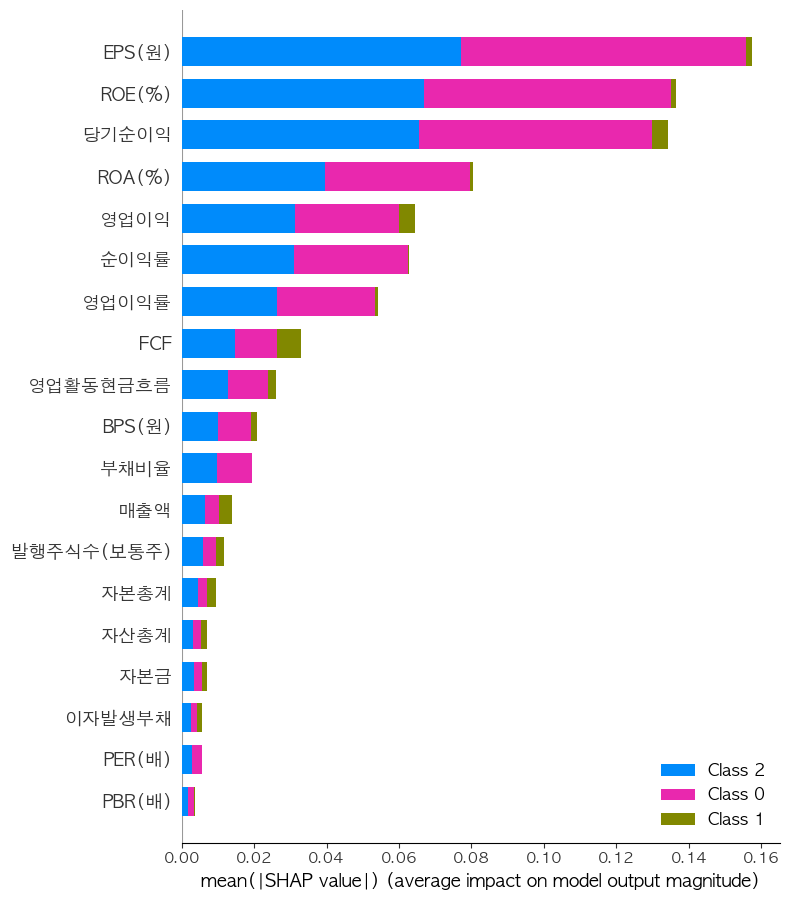

In [84]:
# SHAP 분석
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_scaled)

# feature importance를 시각화함
shap.summary_plot(shap_values, X_raw, plot_type="bar")

### GMM 클러스터링 결과에 종목명을 포함해서 시각화

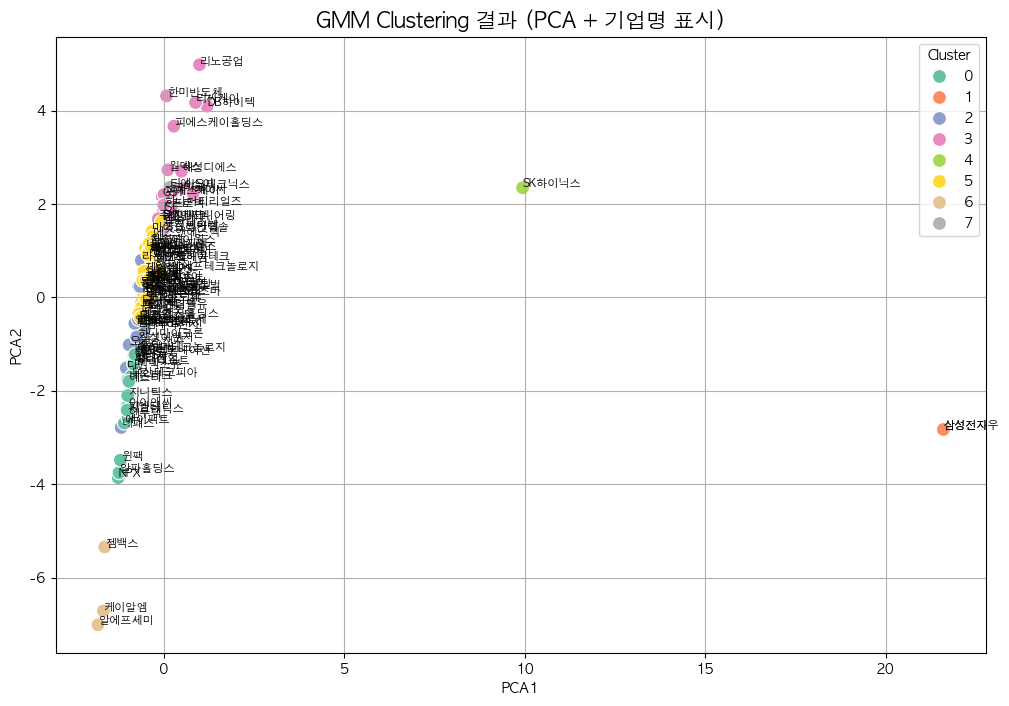

In [ ]:
# 시각화를 위해 PCA로 차원을 축소한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 결과를 dataFrame으로 정리한다. 
df_clustered = pd.DataFrame({
    '기업명': company.values,
    'Cluster': gmm_labels,
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['PCA1'][i]+0.01, df_clustered['PCA2'][i]+0.01, df_clustered['기업명'][i], fontsize=8)
plt.title("GMM Clustering 결과 (PCA + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [ ]:
# 클러스터별 기업 리스트를 출력한다.
for cluster_id in range(gmm.n_components):
    print(f"[클러스터 {cluster_id}에 속한 종목들]:")
    stock_list = company[gmm_labels == cluster_id].values
    print(", ".join(stock_list))


[클러스터 0에 속한 종목들]:
APS, HLB이노베이션, KEC, NPX, 덕산테코피아, 미래산업, 시그네틱스, 아이앤씨, 알파홀딩스, 에이디테크놀로지, 에이팩트, 엔시트론, 엔투텍, 엘티씨, 예스티, 윈팩, 유니테스트, 이엘씨, 지니틱스, 테크엘, 피엠티
[클러스터 1에 속한 종목들]:
삼성전자, 삼성전자우
[클러스터 2에 속한 종목들]:
LB세미콘, 네온테크, 네패스, 뉴파워프라즈마, 다원넥스뷰, 동운아나텍, 라온테크, 매커스, 미코, 신성이엔지, 엠케이전자, 오킨스전자, 원익QnC, 인텍플러스, 칩스앤미디어, 테크윙, 하나마이크론
[클러스터 3에 속한 종목들]:
DB하이텍, GST, ISC, 동진쎄미켐, 두산테스나, 리노공업, 월덱스, 유진테크, 이오테크닉스, 주성엔지니어링, 케이씨, 케이씨텍, 코미코, 티씨케이, 프로텍, 피에스케이, 피에스케이홀딩스, 하나머티리얼즈, 한미반도체, 해성디에스
[클러스터 4에 속한 종목들]:
SK하이닉스
[클러스터 5에 속한 종목들]:
KX하이텍, SFA반도체, 네오셈, 덕산하이메탈, 디아이, 디엔에프, 램테크놀러지, 러셀, 로체시스템즈, 마이크로컨텍솔, 메카로, 브이엠, 서플러스글로벌, 성우테크론, 싸이맥스, 씨앤지하이테크, 아이텍, 아진엑스텍, 어보브반도체, 에스앤에스텍, 에스티아이, 에프에스티, 엑사이엔씨, 엑시콘, 엘오티베큠, 오디텍, 와이씨, 원익IPS, 원익홀딩스, 유니셈, 유니퀘스트, 유니트론텍, 이엔에프테크놀로지, 제너셈, 제우스, 제이티, 제주반도체, 케이엔더블유, 케이엔제이, 코세스, 큐에스아이, 타이거일렉, 테스, 텔레칩스, 피델릭스, 픽셀플러스, 한국전자홀딩스, 한솔아이원스, 한양디지텍
[클러스터 6에 속한 종목들]:
알에프세미, 젬백스, 케이알엠
[클러스터 7에 속한 종목들]:
티에스이
